In [ ]:
#Import the necessary libraries and packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, roc_auc_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load the dataframe
df = pd.read_csv("/content/drive/MyDrive/Datasets/apple_quality.csv")
# Access the top 5 entries
df.head()

A_id      Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
0   0.0 -3.970049 -2.512336   5.346330    -1.012009   1.844900  0.329840   
1   1.0 -1.195217 -2.839257   3.664059     1.588232   0.853286  0.867530   
2   2.0 -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033   
3   3.0 -0.657196 -2.271627   1.324874    -0.097875   3.637970 -3.413761   
4   4.0  1.364217 -1.296612  -0.384658    -0.553006   3.030874 -1.303849   

        Acidity Quality  
0  -0.491590483    good  
1  -0.722809367    good  
2   2.621636473     bad  
3   0.790723217    good  
4   0.501984036    good

In [ ]:
# Concise summary of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4001 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 281.4+ KB


Acidity which contains numeric values is of object data type. So lets convert it to numeric data type.

In [ ]:
# Remove the mismatched data entry
df = df[df["Acidity"] != 'Created_by_Nidula_Elgiriyewithana']
# Convert the acidity column to float
df['Acidity'] = df['Acidity'].astype("float64")

Now all the data types are in the suitable format.

In [ ]:
#Check for null values
df.isnull().sum()

A_id           0
Size           0
Weight         0
Sweetness      0
Crunchiness    0
Juiciness      0
Ripeness       0
Acidity        0
Quality        0
dtype: int64

There are no null values in the dataset.

In [ ]:
#Check for NaN values as well
np.isnan(df.select_dtypes(include="float64")).sum()

A_id           0
Size           0
Weight         0
Sweetness      0
Crunchiness    0
Juiciness      0
Ripeness       0
Acidity        0
dtype: int64

There are no Not a number NaN values as well.

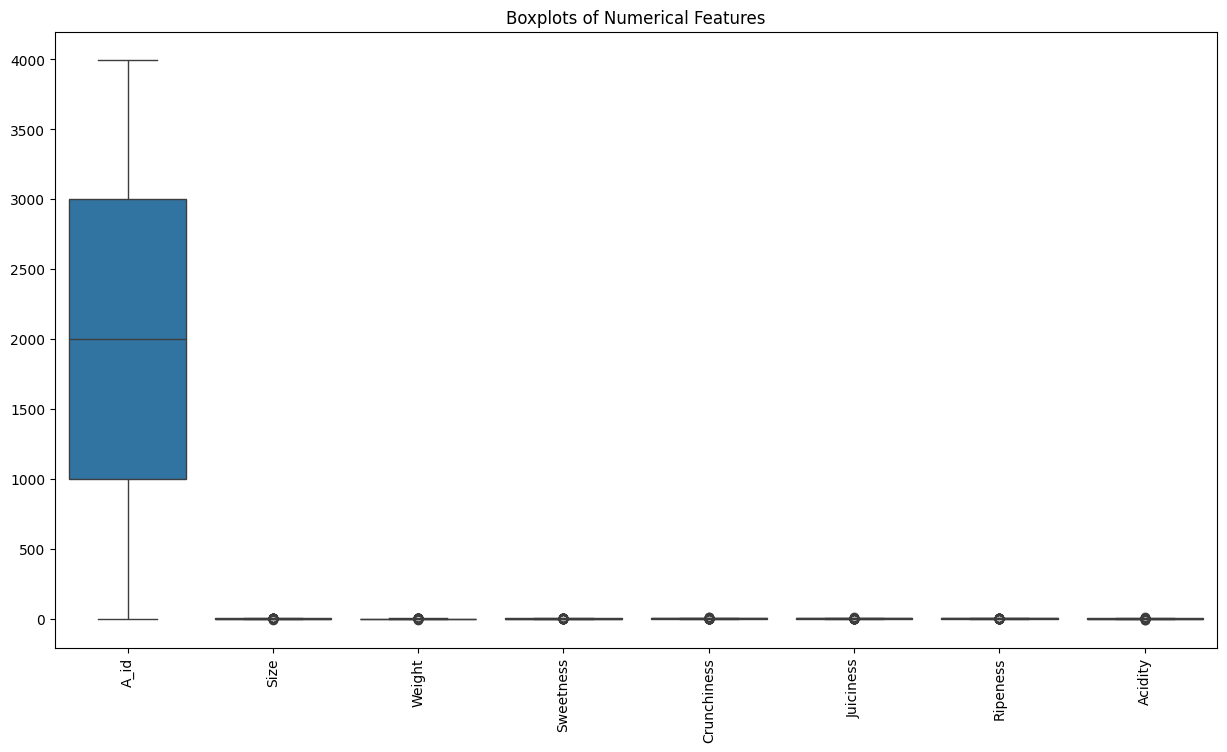

In [ ]:
#Check for outliers
#Function for checking for outliers using boxplot
def outliers_visualizer(X):
  """
    Visualizes the presence of outliers in numerical features using boxplots.

    Parameters:
    X (DataFrame): A Pandas DataFrame containing the dataset.

    Displays:
    A boxplot for numerical (float64) features in the dataset, helping to identify potential outliers.

    Note:
    - The function currently references 'df' instead of 'X', which may cause an error if 'df' is not defined globally.
    - Ensure that 'seaborn' (sns) and 'matplotlib.pyplot' (plt) are imported before calling this function.
    """
  plt.figure(figsize=(15, 8))
  sns.boxplot(data=df.select_dtypes(include=['float64']))
  plt.xticks(rotation=90)  # Rotate labels for readability
  plt.title("Boxplots of Numerical Features")
  plt.show()

#Call the function
outliers_visualizer(df)

There are outliers in features other than A_id. I will clip them.

In [ ]:
#Check for outliers
def check_outliers(X):
  """
    Identifies and clips outliers in numerical features using the Interquartile Range (IQR) method.

    Parameters:
    X (DataFrame): A Pandas DataFrame containing numerical features.

    Returns:
    dict: A dictionary where keys are numerical feature names, and values are the count of outliers detected before clipping.

    Method:
    - Calculates the first quartile (Q1) and third quartile (Q3) for each numerical feature.
    - Computes the interquartile range (IQR) as Q3 - Q1.
    - Determines the lower and upper bounds for outliers as:
      - Lower bound = Q1 - 1.5 * IQR
      - Upper bound = Q3 + 1.5 * IQR
    - Clips values outside these bounds to the respective lower or upper limit.
    - Counts the number of values identified as outliers before clipping.

    Note:
    - The function modifies the original DataFrame by clipping outliers in place.
    - Ensure the dataset is passed as a Pandas DataFrame with floating-point numerical features.
    """
  numercial_features = X.select_dtypes(include = 'float64').columns
  outlier_counts = {}
  for feature in numercial_features:
      Q1 = X[feature].quantile(0.25)
      Q3 = X[feature].quantile(0.75)
      IQR = Q3 - Q1
      lower_limit = Q1 - 1.5 * IQR
      upper_limit = Q3 + 1.5 * IQR
      # Clip the outliers
      X[feature] = X[feature].clip(lower=lower_limit, upper=upper_limit)

    # Store count of outliers
      outliers = X[(X[feature] < lower_limit) | (X[feature] > upper_limit)]
      outlier_counts[feature] = outliers.shape[0]


  return outlier_counts

#Apply the function
check_outliers(df)


{'A_id': 0,
 'Size': 0,
 'Weight': 0,
 'Sweetness': 0,
 'Crunchiness': 0,
 'Juiciness': 0,
 'Ripeness': 0,
 'Acidity': 0}

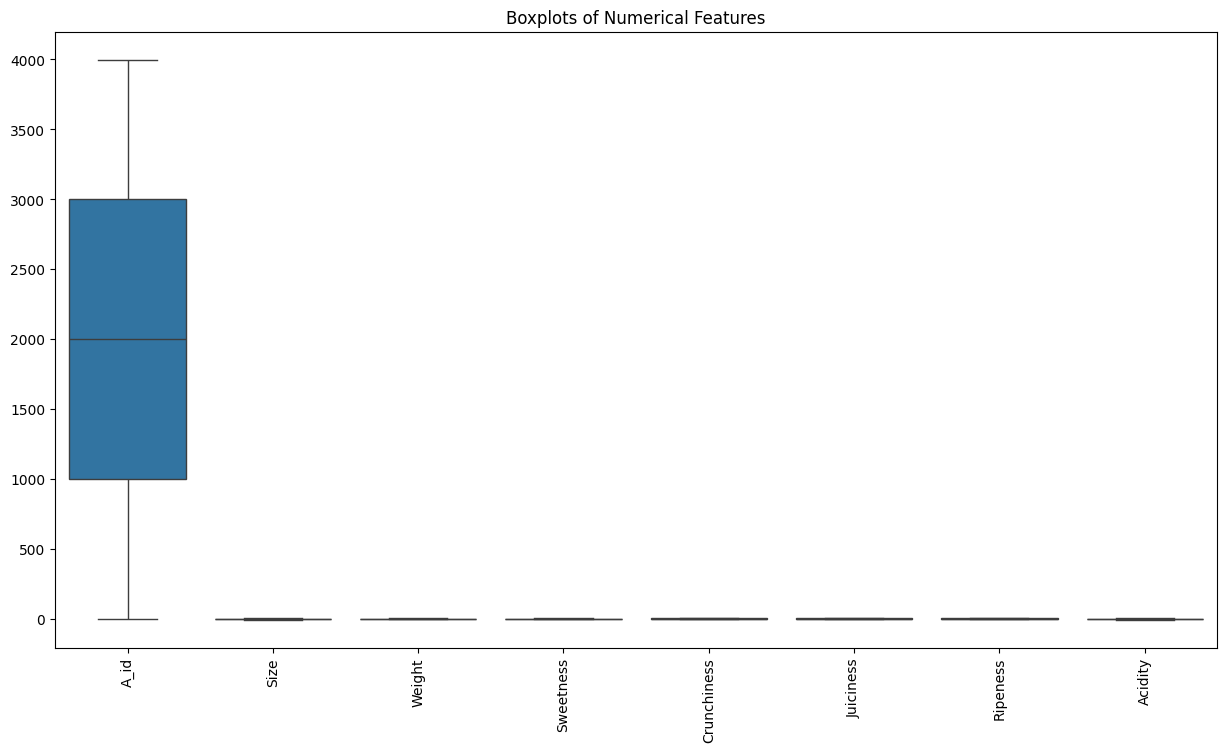

In [ ]:
#Visualize outliers after clipping them
outliers_visualizer(df)

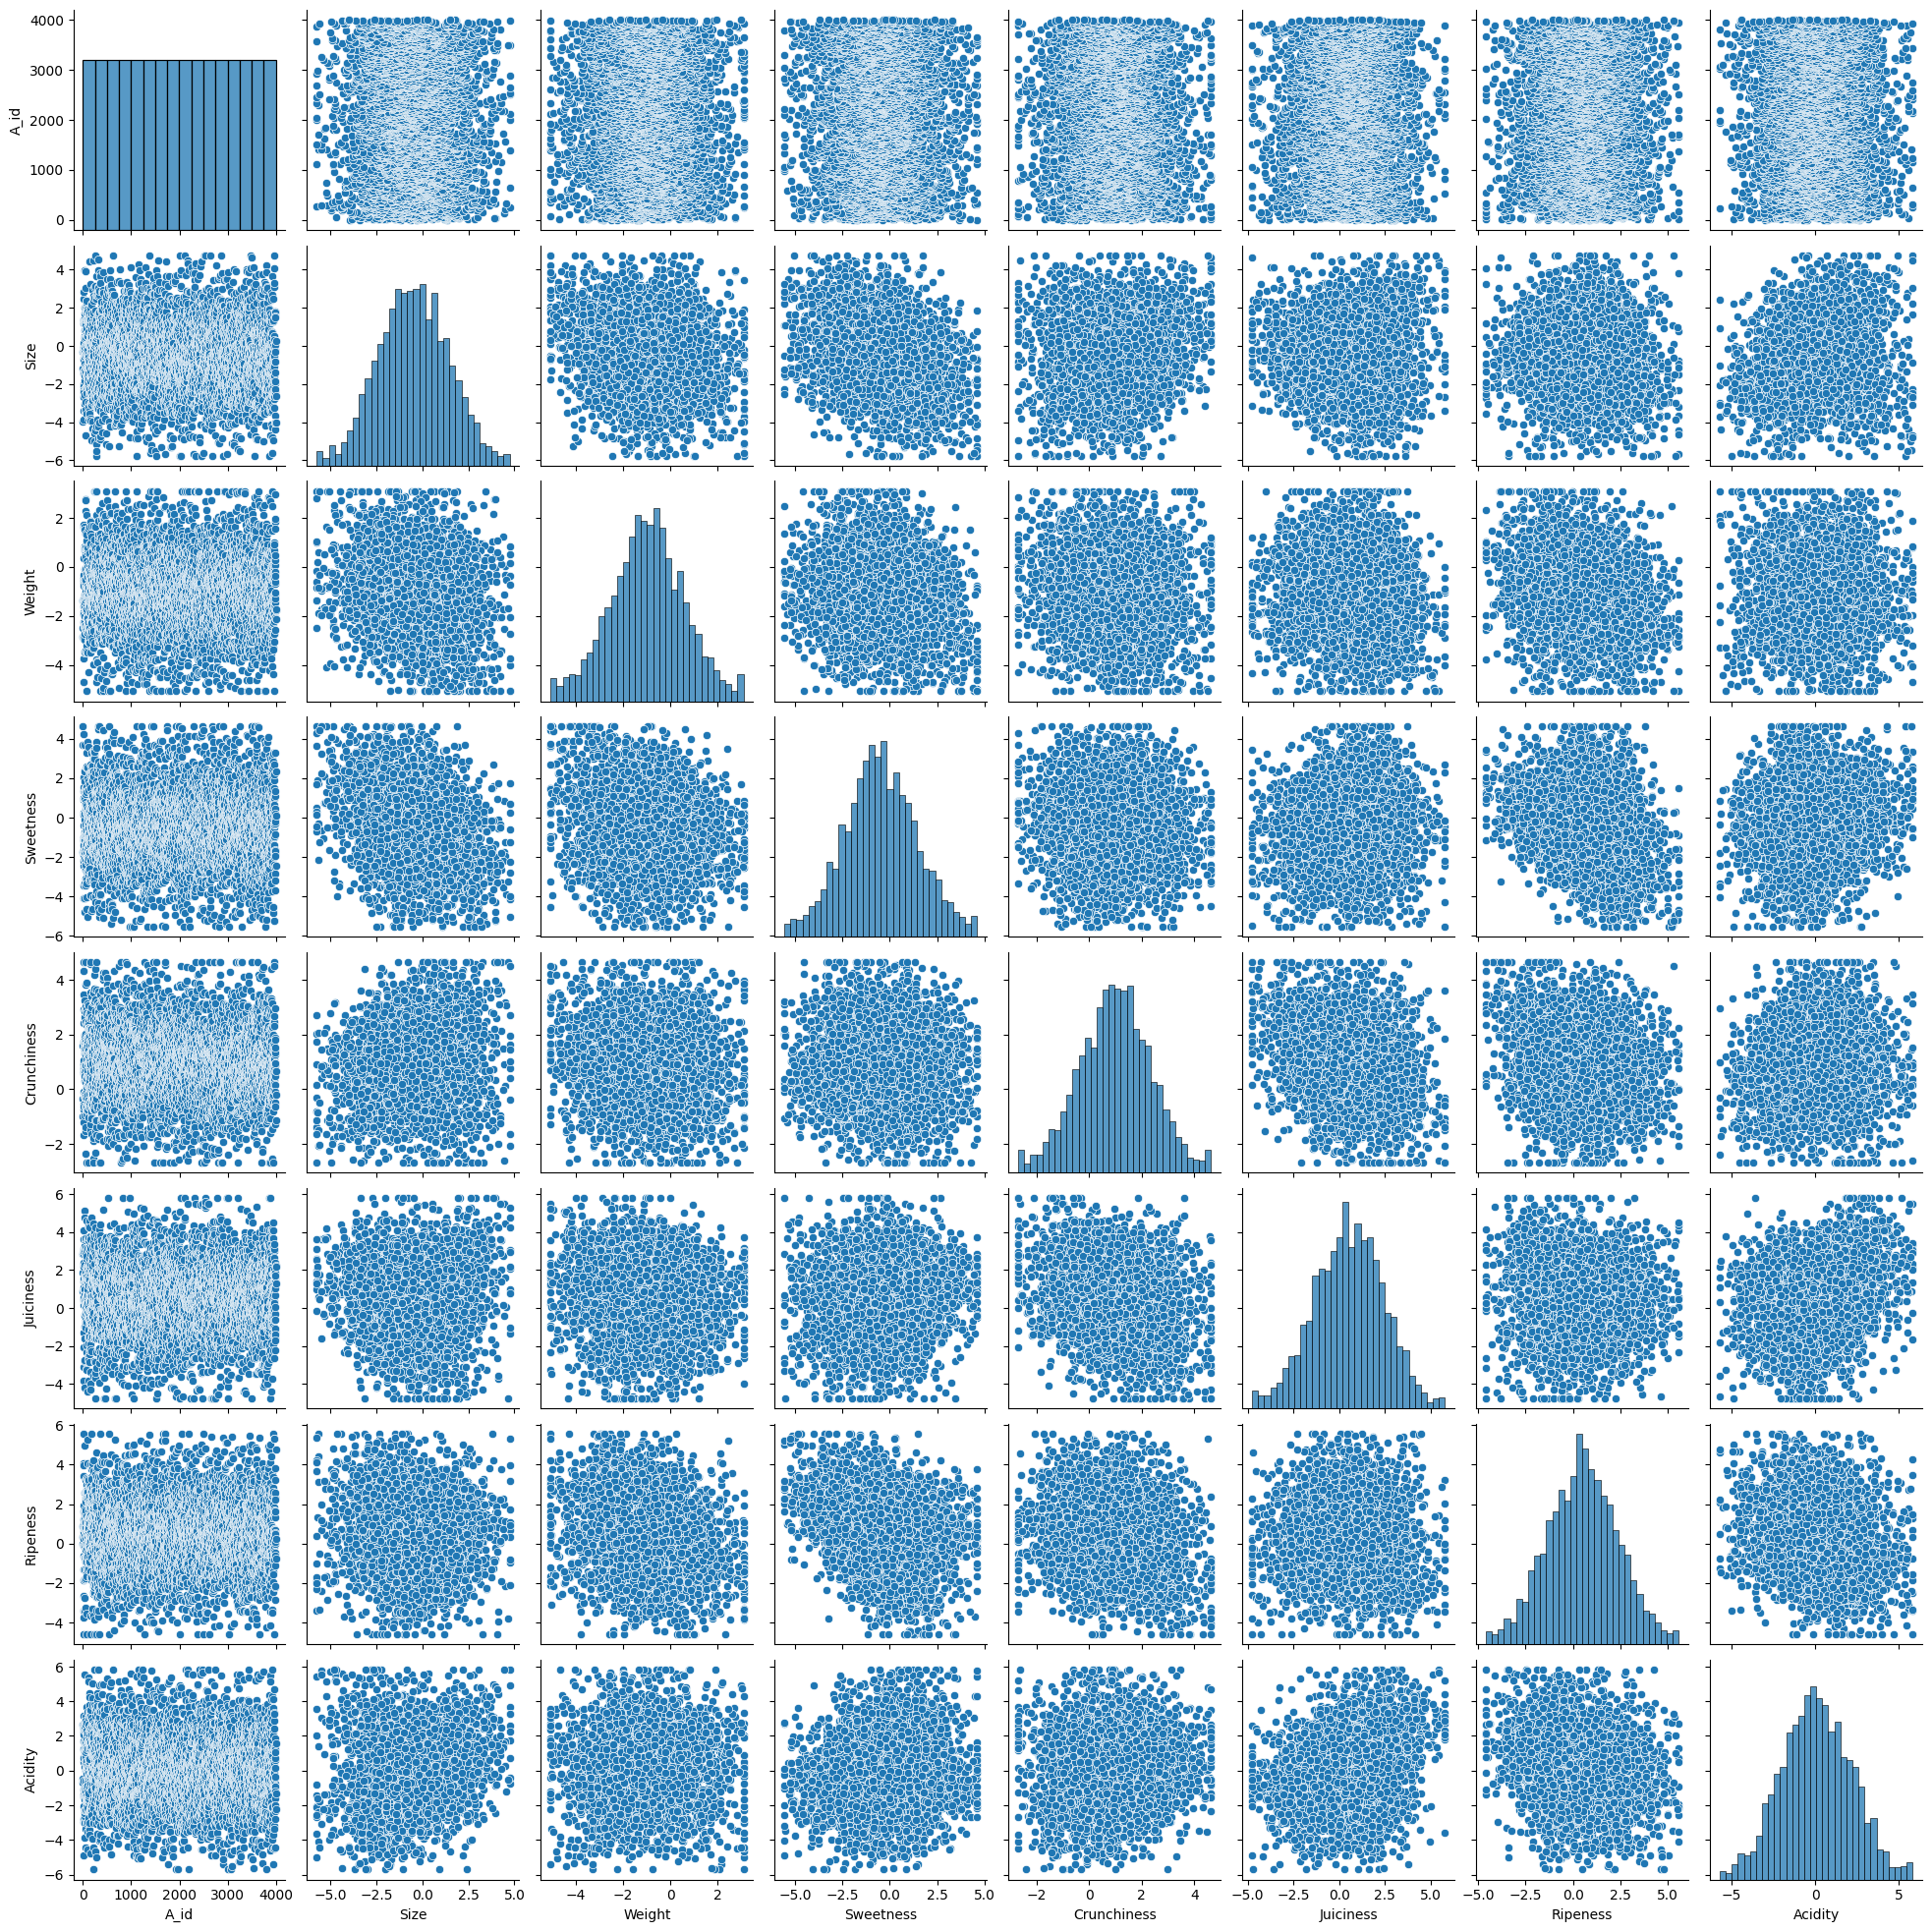

In [ ]:
#Visualize the entire dataset
sns.pairplot(df)

In [ ]:
# Correlation matrix
correlation = df.select_dtypes(include= "float64").corr()
correlation

A_id      Size    Weight  Sweetness  Crunchiness  Juiciness  \
A_id         1.000000 -0.028722 -0.005954  -0.001819    -0.013516   0.005579   
Size        -0.028722  1.000000 -0.166974  -0.324412     0.169820  -0.019437   
Weight      -0.005954 -0.166974  1.000000  -0.152070    -0.095068  -0.092135   
Sweetness   -0.001819 -0.324412 -0.152070   1.000000    -0.033874   0.095436   
Crunchiness -0.013516  0.169820 -0.095068  -0.033874     1.000000  -0.257884   
Juiciness    0.005579 -0.019437 -0.092135   0.095436    -0.257884   1.000000   
Ripeness     0.000252 -0.135910 -0.243678  -0.273578    -0.200391  -0.098975   
Acidity     -0.022019  0.196334  0.019696   0.084710     0.071793   0.248688   

             Ripeness   Acidity  
A_id         0.000252 -0.022019  
Size        -0.135910  0.196334  
Weight      -0.243678  0.019696  
Sweetness   -0.273578  0.084710  
Crunchiness -0.200391  0.071793  
Juiciness   -0.098975  0.248688  
Ripeness     1.000000 -0.201941  
Acidity     -0.201941  1.000000

<Axes: >

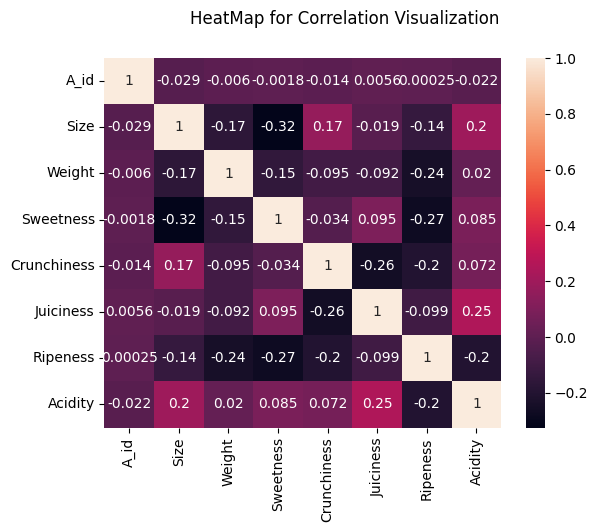

In [ ]:
# Heatmap for visualization of correlation matrix
plt.suptitle("HeatMap for Correlation Visualization")
sns.heatmap(data = correlation, annot = True)

In [ ]:
# Distribution count of categorical feature: Quality
print(df["Quality"].value_counts())
df["Quality"].head()

Quality
good    2004
bad     1996
Name: count, dtype: int64


0    good
1    good
2     bad
3    good
4    good
Name: Quality, dtype: object

Since the Quality is a ordinal categorical feature, we will proceed with label encoding

In [ ]:
# Label Encoding the categorical feature
le = LabelEncoder()
df["Quality"] = le.fit_transform(df["Quality"])
df['Quality'].head()


0    1
1    1
2    0
3    1
4    1
Name: Quality, dtype: int32

1 is assigned to Good labels whereas 0 is assigned to bad labels

In [ ]:
#Splitting the dataset into feature matrix and label vector
X = df.drop(columns=["A_id", "Quality"])
y = df['Quality']

In [ ]:
# Function for train test split
def train_test_split(X, y, test_size = 0.3, random_seed = 42):
    """
    Splits dataset into train and test sets.
    Arguments:
    X : np.ndarray
    Feature matrix.
    y : np.ndarray
    Target array.
    test_size : float
    Proportion of the dataset to include in the test split (0 < test_size < 1).
    random_seed : int
    Seed for reproducibility.
    Returns:
    X_train, X_test, y_train, y_test : np.ndarray
    Training and testing splits of features and target.
    """
    np.random.seed(random_seed)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    test_split_size = int(len(X) * test_size)
    test_indices = indices[:test_split_size]
    train_indices = indices[test_split_size:]
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]

    return X_train, X_test, y_train, y_test
#Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size= 0.3, random_seed= 42)

In [ ]:
# print the shapes of training sets and testing sets
print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(y.shape)
print(y_train.shape)
print(y_test.shape)

(4000, 7)
(2800, 7)
(1200, 7)
(4000,)
(2800,)
(1200,)


In [ ]:
# Standardize the values using normalization
def normalize(df):
    """
    Normalizes numerical features in a DataFrame using min-max scaling.

    Parameters:
    df (DataFrame): A Pandas DataFrame containing numerical features to be normalized.

    Returns:
    DataFrame: A new DataFrame with normalized values, where each feature is scaled to the range [0, 1].

    Method:
    - For each feature, computes the minimum and maximum values.
    - Applies min-max scaling: (value - min) / (max - min).
    - Returns a copy of the DataFrame with the transformed values.

    Note:
    - This function does not modify the original DataFrame; it returns a new normalized DataFrame.
    - Ensure all features in `df` are numerical before calling this function.
    - There is a reference to `X.columns` instead of `df.columns`, which may cause an error. It should be changed to `df.columns`.
    """
    result = df.copy()
    for feature_name in X.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

# Convert numpy arrays back to pandas DataFrames
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Apply normalization to the training and test sets
X_train_normalized = normalize(X_train_df)
X_test_normalized = normalize(X_test_df)

# Print the shapes of the normalized datasets
print(f"X_train_normalized shape: {X_train_normalized.shape}")
print(f"X_test_normalized shape: {X_test_normalized.shape}")

# Print the first few rows of the normalized training set
X_train_normalized.head()

X_train_normalized shape: (2800, 7)
X_test_normalized shape: (1200, 7)


Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness   Acidity
0  0.698440  0.253396   0.435217     0.339790   0.744331  0.413835  0.641801
1  0.803923  0.731067   0.445344     0.672753   0.422351  0.197261  0.548774
2  0.442863  0.615904   0.630405     0.355525   0.696813  0.393274  0.166425
3  0.415697  0.726659   0.330971     0.510273   0.434620  0.594369  0.418281
4  0.595898  0.395743   0.684938     0.297014   0.354345  0.350368  0.620456

In [ ]:
#Check if the target values are proportionally distributed
print(f"Tagret distribution in train label vector:\n{pd.Series(y_train).value_counts()}")
print(f"Tagret distribution in test label vector:\n{pd.Series(y_test).value_counts()}")

Tagret distribution in train label vector:
0    1403
1    1397
Name: count, dtype: int64
Tagret distribution in test label vector:
1    607
0    593
Name: count, dtype: int64


Seems like target values are almost equally distributed

In [ ]:
#Sigmoid Regression from Scratch
class SigmoidRegression:
    """
    A simple implementation of logistic regression using the sigmoid activation function.

    Parameters:
    learning_rate (float): The learning rate used for gradient descent. Default is 0.01.
    iterations (int): The number of iterations for gradient descent. Default is 10,000.

    Attributes:
    learning_rate (float): The learning rate used for gradient descent.
    iterations (int): The number of iterations for gradient descent.
    weights (ndarray): The learned weights of the model.
    bias (float): The learned bias of the model.
    m (int): The number of training examples.
    n (int): The number of features in the dataset.

    Methods:
    sigmoid(z):
        Applies the sigmoid function to the input value z.

    fit(X, y):
        Trains the logistic regression model using gradient descent.
        X (ndarray): The feature matrix (m x n).
        y (ndarray): The target vector (m,).

    predict_proba(X):
        Predicts the probability of the positive class for each sample in X.
        X (ndarray): The feature matrix (m x n).
        Returns: The predicted probabilities (m,).

    predict(X):
        Predicts the binary class labels for each sample in X (0 or 1).
        X (ndarray): The feature matrix (m x n).
        Returns: The predicted class labels (m,).
    """

    def __init__(self, learning_rate=0.01, iterations=10000):
        """
        Initializes the SigmoidRegression model with specified learning rate and iterations.

        Parameters:
        learning_rate (float): The learning rate for gradient descent. Default is 0.01.
        iterations (int): The number of iterations for gradient descent. Default is 10,000.
        """
        self.learning_rate = learning_rate
        self.iterations = iterations

    def sigmoid(self, z):
        """
        Computes the sigmoid of a given input z.

        Sigmoid function: 1 / (1 + exp(-z))

        Parameters:
        z (ndarray or scalar): The input value or array of values to apply the sigmoid function to.

        Returns:
        ndarray or scalar: The result of applying the sigmoid function element-wise to the input.
        """
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        """
        Trains the logistic regression model using gradient descent.

        Parameters:
        X (ndarray): The feature matrix with shape (m, n) where m is the number of samples and n is the number of features.
        y (ndarray): The target vector with shape (m,) containing the true labels for each sample.

        The method updates the weights and bias of the model based on the gradient descent optimization process.
        """
        self.m, self.n = X.shape
        self.weights = np.zeros(self.n)
        self.bias = 0

        for _ in range(self.iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            dw = (1 / self.m) * np.dot(X.T, (y_predicted - y))
            db = (1 / self.m) * np.sum(y_predicted - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict_proba(self, X):
        """
        Predicts the probability of the positive class (label 1) for each sample in the dataset X.

        Parameters:
        X (ndarray): The feature matrix with shape (m, n) where m is the number of samples and n is the number of features.

        Returns:
        ndarray: The predicted probabilities for each sample, in the range [0, 1].
        """
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)

    def predict(self, X):
        """
        Predicts the binary class labels (0 or 1) for each sample in the dataset X.

        Parameters:
        X (ndarray): The feature matrix with shape (m, n) where m is the number of samples and n is the number of features.

        Returns:
        ndarray: The predicted class labels (0 or 1) for each sample.
        """
        y_predicted_proba = self.predict_proba(X)
        y_predicted = [1 if i > 0.5 else 0 for i in y_predicted_proba]
        return np.array(y_predicted)


In [ ]:
# Initialize the model
model = SigmoidRegression(learning_rate=0.01, iterations=10000)
# Fit the model
model.fit(X_train_normalized.values, y_train)
# Make the predictions
predictions = model.predict(X_test_normalized.values)
# Calculate probabilities
probabilities = model.predict_proba(X_test_normalized.values)
# Print the top 5 predictions
print(predictions[:5])


[0 1 1 0 0]


In [ ]:
# Check if the predicted labels are almost distributed or not
pd.Series(predictions).value_counts()

1    609
0    591
Name: count, dtype: int64

Evaluation of the model built from scratch

In [ ]:
# Calculate the metrics
accuracy_scratch = accuracy_score(y_test, predictions)
precision_scratch = precision_score(y_test, predictions)
recall_scratch = recall_score(y_test, predictions)
f1_scratch = f1_score(y_test, predictions)

In [ ]:
# Print the metrics
print(f"Accuracy(Scratch): {accuracy_scratch}")
print(f"Precision(Scratch): {precision_scratch}")
print(f"Recall(Scratch): {recall_scratch}")
print(f"f1(Scratch): {f1_scratch}")

Accuracy(Scratch): 0.7166666666666667
Precision(Scratch): 0.7192118226600985
Recall(Scratch): 0.7215815485996705
f1(Scratch): 0.7203947368421053


As per the metrics, it can be infered that model performed well.


Building two classification model using sklearn

In [ ]:
# Preparing the dataframes of training and testing feature matrix for further model building and training
X_train = pd.DataFrame(X_train, columns= X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)

In [ ]:
# Decision Tree Classifier
decision_tree = DecisionTreeClassifier()
# Fit the model
decision_tree.fit(X_train, y_train)
# Make the predictions
y_pred_tree = decision_tree.predict(X_test)
# Print the top 10 predictions
y_pred_tree[:10]

array([0, 1, 1, 1, 0, 1, 0, 0, 0, 0])

Model Evaluation of Decision Tree Classifier

In [ ]:
# Calculate the evaluation metrics
accuracy_tree = accuracy_score(y_test, y_pred_tree)
precision_tree = precision_score(y_test, y_pred_tree)
recall_tree = recall_score(y_test, y_pred_tree)
f1_tree = f1_score(y_test, y_pred_tree)

In [ ]:
# Print the evaluation metrics
print(f"Accuracy(Tree): {accuracy_tree}")
print(f"Precision(Tree): {precision_tree}")
print(f"Recall(Tree): {recall_tree}")
print(f"f1(Tree): {f1_tree}")

Accuracy(Tree): 0.785
Precision(Tree): 0.7884297520661157
Recall(Tree): 0.785831960461285
f1(Tree): 0.7871287128712872


Looking at the metrics, we can infer that decision tree performed relatively better than the sigmoid regression model built from scratch

In [ ]:
# Initialize the random forest classifier
RFC = RandomForestClassifier()
# Fit the model
RFC.fit(X_train, y_train)

y_pred_rfc = RFC.predict(X_test)
y_pred_rfc[:10]

array([1, 1, 0, 1, 0, 1, 0, 0, 1, 0])

In [ ]:
# Calculate the metrics
accuracy_RFC = accuracy_score(y_test, y_pred_rfc)
precision_RFC = precision_score(y_test, y_pred_rfc)
recall_RFC = recall_score(y_test, y_pred_rfc)
f1_RFC = f1_score(y_test, y_pred_rfc)

# Print the metrics
print(f"Accuracy(RFC): {accuracy_RFC}")
print(f"Precision(RFC): {precision_RFC}")
print(f"Recall(RFC): {recall_RFC}")
print(f"f1(RFC): {f1_RFC}")


Accuracy(RFC): 0.8958333333333334
Precision(RFC): 0.8990066225165563
Recall(RFC): 0.8945634266886326
f1(RFC): 0.8967795210569777


Random Forest Classifier outperformed sigmoid regression and Decision Tree Classifier

Hyperparameter tuning for Decision Tree Classifier With Cross validation

In [ ]:
# Define the parameter grid for Decision Tree
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [ ]:
# Initialize classifiers
dt_clf = DecisionTreeClassifier()

# Initialize RandomizedSearchCV for Decision Tree
dt_random_search = RandomizedSearchCV(
    estimator=dt_clf,
    param_distributions=dt_param_grid,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# Fit the models
dt_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, scoring='accuracy')

In [ ]:
# Get the best parameters and best score for Decision Tree
best_dt_params = dt_random_search.best_params_
best_dt_score = dt_random_search.best_score_

print(f"Best Parameters for Decision Tree: {best_dt_params}")
print(f"Best Score for Decision Tree: {best_dt_score}")

Best Parameters for Decision Tree: {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 30, 'criterion': 'entropy'}
Best Score for Decision Tree: 0.8042857142857145


In [ ]:
# Use the best estimators to make predictions
best_dt_model = dt_random_search.best_estimator_
dt_pred = best_dt_model.predict(X_test)
dt_pred

array([1, 1, 0, ..., 1, 1, 1])

Hyperparameter Tuning for Random Forest Classifier with Cross Validation

In [ ]:
# Define the parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [ ]:
#Instantiate the random forest classifier
rf_clf = RandomForestClassifier()

# Initialize RandomizedSearchCV for Random Forest
rf_random_search = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=rf_param_grid,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

#Fit the model
rf_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 200]},
                   random_state=42, scoring='accuracy')

In [ ]:
# Get the best parameters and best score for Random Forest
best_rf_params = rf_random_search.best_params_
best_rf_score = rf_random_search.best_score_

print(f"Best Parameters for Random Forest: {best_rf_params}")
print(f"Best Score for Random Forest: {best_rf_score}")

Best Parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': True}
Best Score for Random Forest: 0.8735714285714286


In [ ]:
best_rf_model = rf_random_search.best_estimator_
rf_pred = best_rf_model.predict(X_test)
rf_pred

array([1, 1, 0, ..., 1, 0, 1])

Feature Selection for Both Models using Recursive Feature Elimination(RFE)

In [ ]:
# Perform RFE for Decision Tree
rfe_dt = RFE(estimator=dt_clf, n_features_to_select=5)  # Select top 5 features
X_train_selected_dt = rfe_dt.fit_transform(X_train, y_train)
X_test_selected_dt = rfe_dt.transform(X_test)

In [ ]:
# Print selected features for Decision Tree
selected_features_dt = X_train.columns[rfe_dt.support_]
print("Selected features for Decision Tree:", list(selected_features_dt))

Selected features for Decision Tree: ['Size', 'Sweetness', 'Juiciness', 'Ripeness', 'Acidity']


In [ ]:
# Perform RFE for Random Forest
rfe_rf = RFE(estimator=rf_clf, n_features_to_select=5)  # Select top 5 features
X_train_selected_rf = rfe_rf.fit_transform(X_train, y_train)
X_test_selected_rf = rfe_rf.transform(X_test)

In [ ]:
# Print selected features for Random Forest
selected_features_rf = X_train.columns[rfe_rf.support_]
print("Selected features for Random Forest:", list(selected_features_rf))

Selected features for Random Forest: ['Size', 'Sweetness', 'Juiciness', 'Ripeness', 'Acidity']


For both the models, we got the same set of features selected.

Build the final model with best features selected and best estimator(Random Forest)

In [ ]:
#Accessing the selected features
X_train_f_selected = X_train[list(selected_features_rf)]
X_test_f_selected = X_test[list(selected_features_rf)]
print(X_train_f_selected.head())
print()
print(X_test_f_selected.head())

       Size  Sweetness  Juiciness  Ripeness   Acidity
0  1.575850  -1.126534   3.094803 -0.377438  1.704577
1  2.682281  -1.023634  -0.301777 -2.576000  0.629952
2 -1.104934   0.856840   2.593540 -0.586165 -3.786816
3 -1.389891  -2.185817  -0.172354  1.455256 -0.877456
4  0.500270   1.410977  -1.019181 -1.021734  1.458007

       Size  Sweetness  Juiciness  Ripeness   Acidity
0  3.099411  -3.679364   0.538102  1.660099 -0.544761
1  1.439788  -0.061449   0.885641 -2.191811  1.952777
2  1.206786   1.736207  -0.556149 -1.332052  1.009156
3 -1.612077   2.250267  -1.435862  2.388755 -0.487297
4 -1.962900  -2.388917  -2.780126  1.623751 -1.636459


In [ ]:
#Accessing the best rf model given by randomized search cv
best_rf_model.fit(X_train_f_selected, y_train)
y_final_pred = best_rf_model.predict(X_test_f_selected)
y_final_pred

array([1, 1, 0, ..., 0, 0, 1])

Final Model Evaluation

In [ ]:
accuracy_final = accuracy_score(y_test, y_final_pred)
precision_final = precision_score(y_test, y_final_pred)
recall_final = recall_score(y_test, y_final_pred)
f1_final = f1_score(y_test, y_final_pred)
roc_auc_final = roc_auc_score(y_test, y_final_pred)

In [ ]:
# Print the metrics
print(f"Accuracy: {accuracy_final}")
print(f"Precision: {precision_final}")
print(f"Recall: {recall_final}")
print(f"F1 Score: {f1_final}")
print(f"ROC AUC Score: {roc_auc_final}")

Accuracy: 0.8441666666666666
Precision: 0.8465346534653465
Recall: 0.8451400329489291
F1 Score: 0.8458367683429514
ROC AUC Score: 0.8441551766768254


In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_final_pred)
conf_matrix

array([[500,  93],
       [ 94, 513]], dtype=int64)

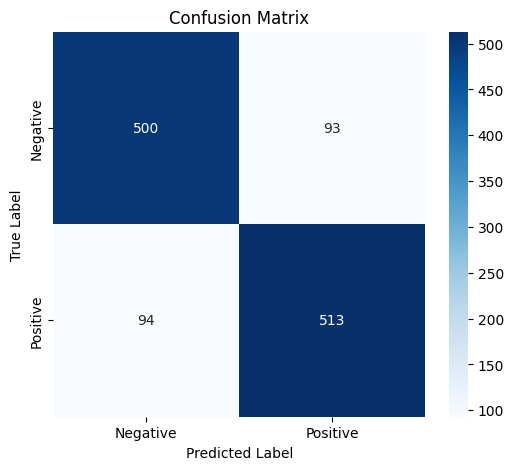

In [ ]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

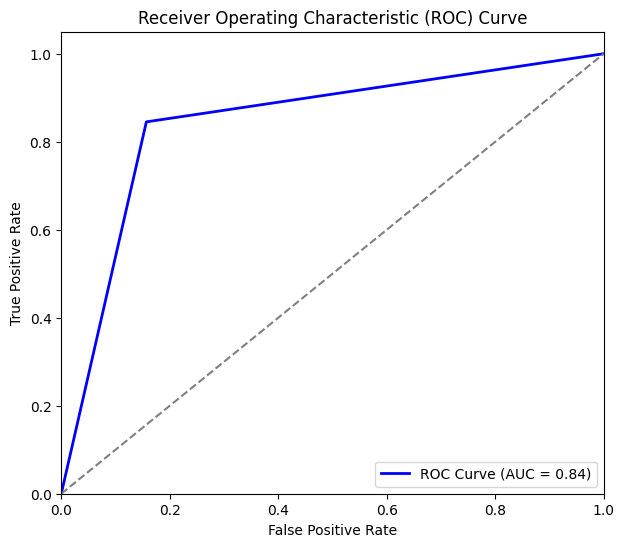

In [ ]:
# ROC AUC Curve Visualization
fpr, tpr, _ = roc_curve(y_test, y_final_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The final model performs well, achieving high accuracy, precision, recall, and F1 score. It effectively differentiates between positive and negative cases, with a good balance between false positives and false negatives. However, there is room for improvement, particularly in reducing false positives (FP = 96) and false negatives (FN = 86), which could be optimized by adjusting classification thresholds or fine-tuning hyperparameters.